<small><i>This notebook is based on the article [Customer Segmentation in Python](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by Greg Lamp.</i></small>

<small><i>With updates by Volh Hedranovich.</i></small>

# Customer Segmentation in Python

At the core of customer segmentation is being able to identify different types of customers and then figure out ways to find more of those individuals so you can... you guessed it, get more customers! One can use K-Means clustering to help with some of the exploratory aspects of customer segmentation.

### Data

The data we're using comes from John Foreman's book [Data Smart](http://www.john-foreman.com/data-smart-book.html). The [dataset](http://blog.yhat.com/static/misc/data/WineKMC.xlsx) contains both information on marketing newsletters / e-mail campaigns (e-mail offers sent) and transaction level data from customers (which offer customers responded to and what they bought).

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ggplot import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline

In [4]:
df_offers = pd.read_excel("data/WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [5]:
df_transactions = pd.read_excel("data/WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


### Pre-processing data

Since we're trying to learn more about how the customers behave, we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a <b>0/1 indicator</b> for whether or not they responded to a given offer.

* Join the offers and transactions table:

In [7]:
df = pd.merge(df_offers, df_transactions)
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1



* Create a "pivot table" which will give us the number of times each customer responded to a given variable:

In [85]:
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


* A little tidying up. Fill NaN values with 0 and make the index into a column:

In [86]:
matrix = matrix.fillna(0).reset_index()
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [87]:
x_cols = matrix.columns[1:]
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

### Clustering
Now to create the clusters, we're going to use the <b>KMeans</b> functionality from scikit-learn. <i>"I arbitrarily chose 5 clusters. My general rule of thumb is to have at least 7x as many records as I do clusters." (Greg Lamp)</i>

In [88]:
cluster = KMeans(n_clusters=5)

* Slice matrix so we only include the <b>0/1 indicator</b> columns in the clustering:

In [89]:
matrix['cluster'] = cluster.fit_predict(matrix[x_cols])
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2


In [90]:
matrix.cluster.value_counts()

2    33
3    20
0    18
1    16
4    13
Name: cluster, dtype: int64

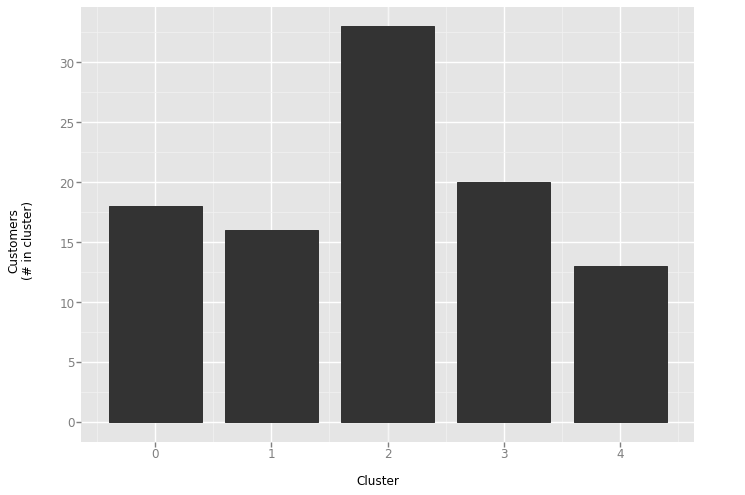

<ggplot: (8772389067461)>

In [91]:
ggplot(matrix, aes(x='cluster')) + geom_bar() + xlab("Cluster") + ylab("Customers\n(# in cluster)")

### Visualizing the clusters

In [92]:
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()
matrix.head()

offer_id,index,customer_name,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,cluster,x,y
0,0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3,1.007580,0.108215
1,1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,-0.287539,0.044715
2,2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.392032,1.038391
3,3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,0.699477,-0.022542
4,4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,0.088183,-0.471695


In [93]:
customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]
customer_clusters.head()

offer_id,customer_name,cluster,x,y
0,Adams,3,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,1,-0.392032,1.038391
3,Bailey,3,0.699477,-0.022542
4,Baker,2,0.088183,-0.471695


What we've done is we've taken those x_cols columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it x and then called the other y. Now we can throw each point into a scatterplot. We'll color code each point based on it's cluster so it's easier to see them.

In [94]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster,x,y
0,1,January,Malbec,72,56,France,False,Thomas,1,2,-1.041879,0.122314
1,1,January,Malbec,72,56,France,False,Jackson,1,0,-0.839578,-0.328823
2,1,January,Malbec,72,56,France,False,Mitchell,1,2,-0.342938,0.302186
3,1,January,Malbec,72,56,France,False,Peterson,1,1,-0.797379,0.475995
4,1,January,Malbec,72,56,France,False,Wood,1,2,-0.551215,-0.395670


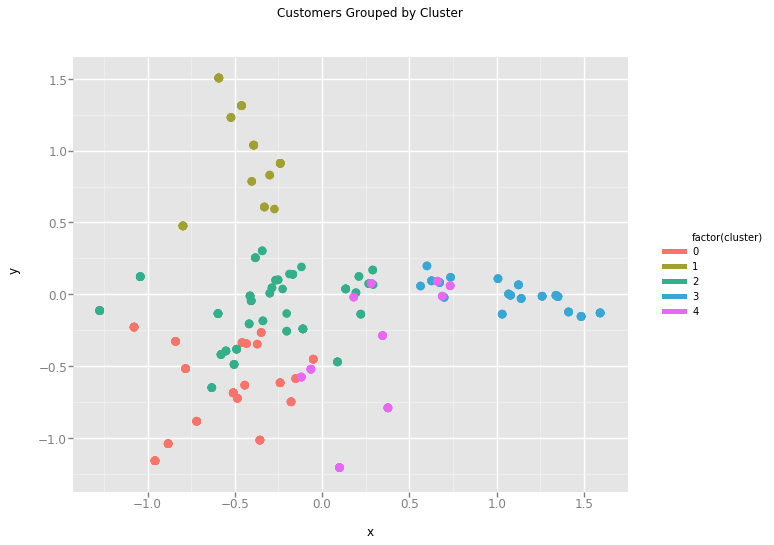

<ggplot: (-9223363264465749216)>

In [95]:
gg = ggplot(df, aes(x='x', y='y', color='factor(cluster)')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster")
gg

We can get the centers of the clusters as well. These are stored in the KMeans instance using the cluster_centers_ variable. Make sure that you also transform the cluster centers into the 2-D projection.

In [96]:
cluster.cluster_centers_[0,]

array([ 2.77777778e-01,  1.11111111e-01,  1.11111111e-01,  2.22222222e-01,
        5.55555556e-02,  2.77777778e-01,  5.55555556e-02, -5.55111512e-17,
        1.11111111e-01,  1.11111111e-01,  2.22222222e-01,  1.11111111e-01,
       -2.77555756e-17,  2.22222222e-01,  2.22222222e-01, -1.38777878e-17,
       -2.77555756e-17,  5.55555556e-02,  5.55555556e-02,  5.55555556e-02,
        5.55555556e-02,  1.00000000e+00,  1.11111111e-01, -5.55111512e-17,
        1.11111111e-01,  5.55555556e-02,  1.66666667e-01,  1.11111111e-01,
        5.55111512e-17,  2.22222222e-01,  3.33333333e-01,  5.55555556e-02])

In [97]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))
cluster_centers

,x,y,cluster
0,-0.515802,-0.607360,0
1,-0.414356,1.000940,1
2,-0.260389,-0.071882,2
3,1.004818,0.012379,3
4,0.339278,-0.227540,4


### Understanding the clusters

Let's dig a little deeper into the clusters. Take cluster 3 for example. If we break out cluster 3 and compare its customers to the remaining customers, we can start to look for interesting facets that we might be able to exploit.

In [105]:
df['research'] = df.cluster==3
df.groupby("research").varietal.value_counts()

research  varietal          
False     Champagne             81
          Pinot Noir            44
          Cabernet Sauvignon    32
          Prosecco              31
          Espumante             23
          Malbec                17
          Chardonnay            15
          Merlot                15
          Pinot Grigio           4
True      Espumante             17
          Malbec                15
          Pinot Grigio          13
          Prosecco              12
          Merlot                 5
Name: varietal, dtype: int64

In [106]:
df.groupby("research")[['min_qty', 'discount']].mean()

,min_qty,discount
research,,
False,70.80916,60.385496
True,6.00000,55.661290


In [104]:
df.groupby("cluster")[['min_qty', 'discount']].mean()

,min_qty,discount
cluster,,
0,79.259259,61.382716
1,65.581395,52.116279
2,77.820000,64.820000
3,6.000000,55.661290
4,40.263158,55.947368
